## Importing libraries 

In [1]:
import os 
import cv2 
import copy 
import time 
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset
from PIL import Image
from scipy import ndimage as ndi
from torchsummary import summary
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [3]:
os.getcwd()

'/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/Python_Script'

In [2]:
img_path = '/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/Python_Script/data/images'
mask_path = '/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/Python_Script/data/masks'
img_list = os.listdir(img_path)
mask_list = os.listdir(mask_path)

print('Number of Imges :', len(img_list))
print('Number of Masks: ', len(mask_list))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/Python_Script/data/images'

In [173]:

np.random.seed(2019)
rndImgs=np.random.choice(img_list,4)
rndImgs


array(['223_2HC.png', '022_2HC.png', '284_HC.png', '314_HC.png'],
      dtype='<U11')

## Data Visualization

In [174]:

def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
        
        
    img_mask=mark_boundaries(np.array(img), 
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)

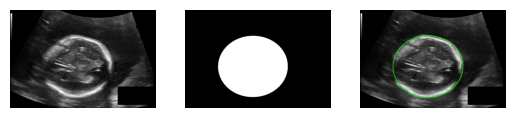

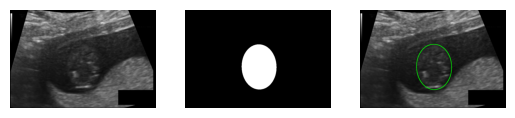

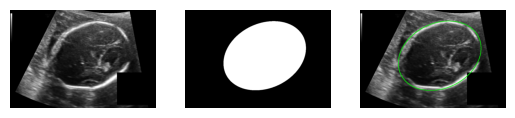

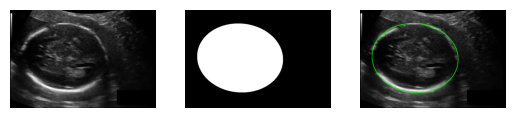

In [175]:
for fn in rndImgs :
    path2img = os.path.join(img_path, fn)
    path2annt= path2img.replace("/images/","/masks/")
    path2annt = path2annt.replace('.png', '_Annotation.png')
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)        

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 2) 
    plt.imshow(mask, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask)
    plt.axis('off')

## Data Argumentation 

In [176]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,    
    Compose,
    Resize,
)

h,w=128,192
transform_train = Compose([ Resize(h,w), 
                HorizontalFlip(p=0.5), 
                VerticalFlip(p=0.5), 
              ])


transform_val = Resize(h,w)

## Data Preparation 

In [177]:
# Custumizing the data set 
class Data(Dataset):
    def __init__(self, data_path, transform=None):      

        self.path2imgs = [os.path.join(data_path, fn) for fn in img_list]
        self.path2annts= [f2.replace('/images/', '/masks/').replace('.png', '_Annotation.png') for f2 in self.path2imgs ] 
        self.transform = transform
    
    def __len__(self):
        return len(self.path2imgs)
      
    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)

        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)        
        
        image= np.array(image)
        mask=mask.astype("uint8")        

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']            

        image= to_tensor(image)            
        mask=255*to_tensor(mask)            
        return image, mask

In [178]:
# Applying Transformation 
data_1  = Data(data_path =img_path, transform= transform_train)
len(data_1)
data_2 = Data(data_path = img_path, transform= transform_val)

In [179]:
# data shape checking checking for training 
img, mask = data_1[3]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))


torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


In [180]:
# data splitting
from sklearn.model_selection import ShuffleSplit

data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(data_1))

for train_index, val_index in data_split.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))


497
----------
125


In [181]:

train_data=Subset(data_1,train_index)
print(len(train_data))

val_data=Subset(data_2,val_index)
print(len(val_data))

497
125


### Visualization of Train data and Val data 

(-0.5, 191.5, 127.5, -0.5)

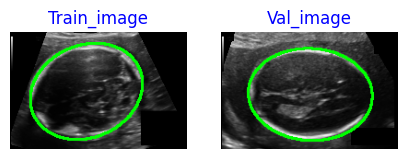

In [182]:
plt.figure(figsize=(5,10))
plt.subplot(121)
plt.title('Train_image', color = 'blue')
for img,mask in train_data:
    show_img_mask(img,mask)
    break
plt.axis('off')
plt.subplot(122)
plt.title('Val_image', color = 'blue')
for img,mask in val_data:
    show_img_mask(img,mask)
    break
plt.axis('off')

## Data Loading 

In [183]:
from torch.utils.data import DataLoader
train_data_load = DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=True)
val_data_load= DataLoader(val_data, batch_size=8, shuffle=False, pin_memory=True)

In [184]:
# checking the shapes of the input
for img_b, mask_b in train_data_load:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([4, 1, 128, 192]) torch.float32
torch.Size([4, 1, 128, 192]) torch.float32


## Semantic Segmentation Model 

In [185]:
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_outputs=params["num_outputs"] 

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv5(x)
        x = F.relu(x)

        x=self.upsample(x)
        x = self.conv_up1(x)
        x = F.relu(x)

        x=self.upsample(x)
        x = self.conv_up2(x)
        x = F.relu(x)
        
        x=self.upsample(x)
        x = self.conv_up3(x)
        x = F.relu(x)
        
        x=self.upsample(x)
        x = self.conv_up4(x)
        x = F.relu(x)

        x = self.conv_out(x)
        
        return x 
    
    

In [186]:
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16, 
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [187]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [188]:
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [189]:

summary(model, input_size=(1, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

## Dice Loss, Binary Cross Entropy with Logits(BCE ) 

In [190]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    
    dice= 2.0 * (intersection + smooth) / (union+ smooth)    
    loss = 1.0 - dice
    
    return loss.sum(), dice.sum()

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')
    
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    
    loss = bce  + dlv

    return loss
def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    
    return metric
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    with torch.no_grad():
        pred= torch.sigmoid(output)
        _, metric_b=dice_loss(pred, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()      

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    
    metric=running_metric/float(len_data)
    
    return loss, metric

## Optimizer

In [191]:
opt = optim.Adam(model.parameters(), lr=3e-4)  # adam optimizer 
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


### Model Training 

In [192]:
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    model_weights =params["model_weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf') 

    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   
        
        start_time = time.time()
        # model training 
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # model evaluation 
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) 
            torch.save(model.state_dict(), model_weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        epoch_time = time.time() - start_time
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("Epoch Time: {} seconds".format(epoch_time))
        print("-"*15) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history  
    
model_weights= "./model_weights/"
if not os.path.exists(model_weights):
        os.mkdir(model_weights)

params_train={
    "num_epochs": 30,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_data_load,
    "val_dl": val_data_load,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "model_weights": model_weights+"hypothesis_1_full_saved_path.pth",
}


# Training the Model 
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/29, current lr=0.0003


Copied best model weights!
train loss: 11685.250193, dice: 40.05
val loss: 8598.054219, dice: 49.78
Epoch Time: 44.629480838775635 seconds
---------------
Epoch 1/29, current lr=0.0003
Copied best model weights!
train loss: 7156.898919, dice: 62.76
val loss: 5447.116953, dice: 70.60
Epoch Time: 40.14843797683716 seconds
---------------
Epoch 2/29, current lr=0.0003
Copied best model weights!
train loss: 5453.017311, dice: 71.66
val loss: 4542.768734, dice: 73.56
Epoch Time: 39.5446240901947 seconds
---------------
Epoch 3/29, current lr=0.0003
Copied best model weights!
train loss: 4760.329785, dice: 74.86
val loss: 4276.605992, dice: 77.50
Epoch Time: 38.759220123291016 seconds
---------------
Epoch 4/29, current lr=0.0003
Copied best model weights!
train loss: 3896.666910, dice: 79.09
val loss: 3519.933234, dice: 79.45
Epoch Time: 38.67810583114624 seconds
---------------
Epoch 5/29, current lr=0.0003
train loss: 3298.790466, dice: 81.77
val loss: 3727.011758, dice: 80.02
Epoch Time:

## Dice Similarity Coffiecient = 92.89 

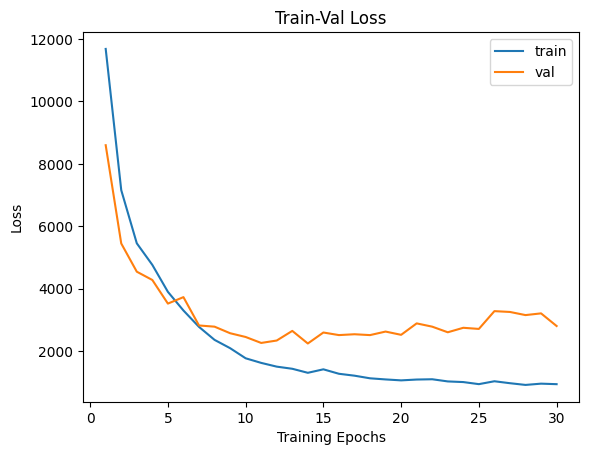

In [209]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

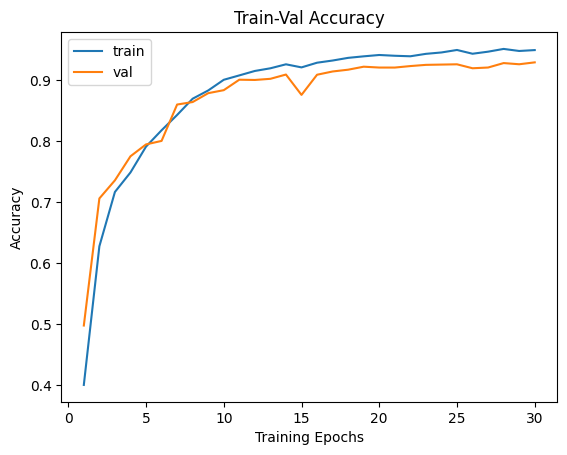

In [210]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


# Making Predictions 

In [217]:
# load model weights 
os.getcwd()
weights_path = '/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/Model_Weights/hypothesis_1_full_saved_path.pth'
model.load_state_dict(torch.load(weights_path))
model.eval()

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

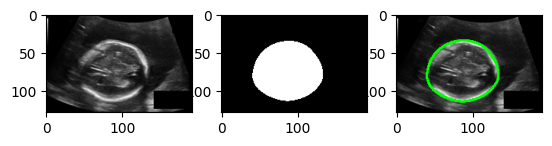

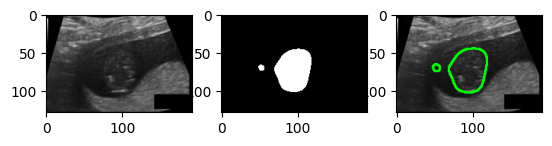

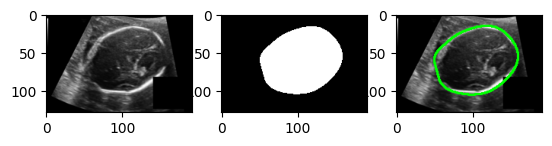

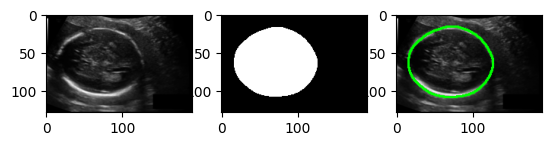

In [237]:
output_path = '/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/'
predicted_masks = []
for fn in rndImgs:
    path2img = os.path.join(img_path, fn)
    img = Image.open(path2img)
    img=img.resize((w,h))
    img_t=to_tensor(img).unsqueeze(0).to(device)
    
    
    pred = model(img_t)
    pred=torch.sigmoid(pred)[0]
    mask_pred= (pred[0]>=0.5).cpu().numpy() * 255
    mask_path = os.path.join(output_path, f"{os.path.splitext(fn)[0]}_mask.png")
    Image.fromarray(mask_pred.astype('uint8')).save(mask_path)

    predicted_masks.append(mask_path)

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask_pred, cmap="gray")
    
    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask_pred)

#### Yeaasss...loooks pretty goodd

## Finding 2 biometry points on Predicted masks 

In [239]:
data = os.listdir('/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/Predicted_masks')
output_path = '/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/Predicted_masks'

def detect_and_draw_biometry_points(image_paths, bpd_ofd_path= ''):
    biometry_points_list = []

    for image_path in image_paths:
        # Load the image
        data_path = '/Users/rocky07/Desktop/Rocky2.0/Rakesh_Ganji_Research/task_1_segmentation/Predicted_masks'
        paths = os.path.join(data_path, image_path)
        image = Image.open(paths).convert('L')  # Convert to grayscale
        mask = np.array(image)

        # Threshold the image to obtain a binary mask
        _, binary_mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

    
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
           
            continue

        # Fit an ellipse to the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        if len(largest_contour) < 5:
          
            continue

        ellipse = cv2.fitEllipse(largest_contour)

        # Extract ellipse parameters
        center, axes, angle = ellipse
        major_axis_endpoint1 = (int(center[0] + axes[0] * 0.5 * np.cos(np.radians(angle))),
                                int(center[1] + axes[0] * 0.5 * np.sin(np.radians(angle))))
        major_axis_endpoint2 = (int(center[0] - axes[0] * 0.5 * np.cos(np.radians(angle))),
                                int(center[1] - axes[0] * 0.5 * np.sin(np.radians(angle))))

        # Calculate minor axis endpoints
        minor_axis_length = axes[1]
        minor_axis_endpoint1 = (int(center[0] + minor_axis_length * 0.5 * np.cos(np.radians(angle + 90))),
                                int(center[1] + minor_axis_length * 0.5 * np.sin(np.radians(angle + 90))))
        minor_axis_endpoint2 = (int(center[0] - minor_axis_length * 0.5 * np.cos(np.radians(angle + 90))),
                                int(center[1] - minor_axis_length * 0.5 * np.sin(np.radians(angle + 90))))
        # Draw major axis
        cv2.line(binary_mask, (int(center[0]), int(center[1])),
                 (int(major_axis_endpoint1[0]), int(major_axis_endpoint1[1])), 255, 1)
        cv2.line(binary_mask, (int(center[0]), int(center[1])),
                 (int(major_axis_endpoint2[0]), int(major_axis_endpoint2[1])), 255, 1)

        # Draw minor axis
        cv2.line(binary_mask, (int(center[0]), int(center[1])),
                 (int(minor_axis_endpoint1[0]), int(minor_axis_endpoint1[1])), 128, 1)
        cv2.line(binary_mask, (int(center[0]), int(center[1])),
                 (int(minor_axis_endpoint2[0]), int(minor_axis_endpoint2[1])), 128, 1)
        output_image_path = os.path.join(output_path, f"{os.path.splitext(image_path)[0]}_axes.png")
        cv2.imwrite(output_image_path, binary_mask)
        # Append biometry points to the list
        biometry_points_list.append({
            'center': center,
            'OFD1': major_axis_endpoint1,
            'OFD2': major_axis_endpoint2,
            'BPD1': minor_axis_endpoint1,
            'BPD2': minor_axis_endpoint2
            
        })

    return biometry_points_list


biometry_points = detect_and_draw_biometry_points(image_paths=data, bpd_ofd_path = output_path)
print("Biometry Points:", biometry_points)


Biometry Points: [{'center': (95.54850006103516, 72.44781494140625), 'OFD1': (117, 79), 'OFD2': (73, 65), 'BPD1': (87, 100), 'BPD2': (103, 44)}, {'center': (71.482666015625, 62.932334899902344), 'OFD1': (70, 107), 'OFD2': (72, 18), 'BPD1': (17, 62), 'BPD2': (125, 63)}, {'center': (105.45870208740234, 60.55366897583008), 'OFD1': (119, 99), 'OFD2': (91, 21), 'BPD1': (53, 79), 'BPD2': (156, 41)}, {'center': (87.18587493896484, 74.29080200195312), 'OFD1': (88, 112), 'OFD2': (85, 35), 'BPD1': (41, 75), 'BPD2': (132, 72)}]


In [242]:
import pandas as pd 
biometry_points = pd.DataFrame(biometry_points)
biometry_points

,center,OFD1,OFD2,BPD1,BPD2
0,"(95.54850006103516, 72.44781494140625)","(117, 79)","(73, 65)","(87, 100)","(103, 44)"
1,"(71.482666015625, 62.932334899902344)","(70, 107)","(72, 18)","(17, 62)","(125, 63)"
2,"(105.45870208740234, 60.55366897583008)","(119, 99)","(91, 21)","(53, 79)","(156, 41)"
3,"(87.18587493896484, 74.29080200195312)","(88, 112)","(85, 35)","(41, 75)","(132, 72)"


## Experiment with U - Net 

In [206]:
import segmentation_models_pytorch as smp
import tqdm as tqdm  

unet_model = smp.Unet(
    encoder_name= 'resnet18', 
    in_channels= 1, 
    classes= 1,
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/rocky07/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.6MB/s]


In [207]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

In [208]:
num_epochs = 10

for epoch in range(num_epochs):
    unet_model.train()
    
    for inputs, targets in train_data_load:
        optimizer.zero_grad()
        outputs = unet_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation step after each epoch
    unet_model.eval()
    with torch.no_grad():
        for val_inputs, val_targets in val_data_load:
            val_outputs = unet_model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 1/10, Loss: 0.1160847544670105, Val Loss: 0.08713050186634064
Epoch 2/10, Loss: 0.046067167073488235, Val Loss: 0.234910786151886
Epoch 3/10, Loss: 0.08479205518960953, Val Loss: 0.05044031888246536
Epoch 4/10, Loss: 0.06342469900846481, Val Loss: 0.0379217304289341
Epoch 5/10, Loss: 0.02816925384104252, Val Loss: 0.033384740352630615
Epoch 6/10, Loss: 0.029497412964701653, Val Loss: 0.03664683923125267
Epoch 7/10, Loss: 0.042642105370759964, Val Loss: 0.033495981246232986
Epoch 8/10, Loss: 0.040983207523822784, Val Loss: 0.03474976494908333
Epoch 9/10, Loss: 0.04552146792411804, Val Loss: 0.03447641432285309
Epoch 10/10, Loss: 0.03279588744044304, Val Loss: 0.038590963929891586


## Loss  : 0.32 and  Val loss : 0.038 

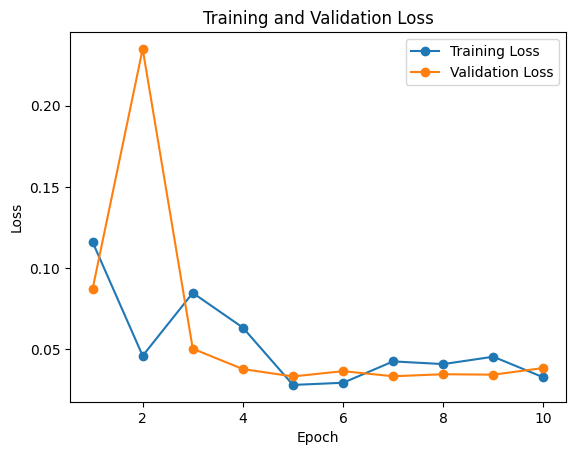

In [240]:
import matplotlib.pyplot as plt

# Provided loss values
epoch_losses = [0.1160847544670105, 0.046067167073488235, 0.08479205518960953, 0.06342469900846481, 0.02816925384104252, 
                0.029497412964701653, 0.042642105370759964, 0.040983207523822784, 0.04552146792411804, 0.03279588744044304]

val_losses = [0.08713050186634064, 0.234910786151886, 0.05044031888246536, 0.0379217304289341, 0.033384740352630615,
              0.03664683923125267, 0.033495981246232986, 0.03474976494908333, 0.03447641432285309, 0.03859096392989158]

# Plotting the losses
epochs = range(1, len(epoch_losses) + 1)

plt.plot(epochs, epoch_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [211]:
#save the model 
torch.save(unet_model.state_dict(), 'unet_model.pth')